<a href="https://colab.research.google.com/github/pepperamy/disclosure_change/blob/main/disclusre_change_data_prepare_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [11]:
from google.colab import drive

drive.mount('/content/drive')

import sys, os
cur_path = os.path.join('/content/drive/My Drive/change','data')
os.chdir(cur_path)
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/change/data


In [ ]:
import random, pickle
import numpy as np
from torch.nn import BCEWithLogitsLoss, BCELoss, MSELoss
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
import tensorflow as tf
import torch
import pandas as pd

!pip install transformers
from transformers import AutoConfig, AutoModel, AutoTokenizer, AutoModelForSequenceClassification

!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

!pip install torchinfo
from torchinfo import summary
from sklearn.model_selection import train_test_split, StratifiedKFold

import copy
from sklearn.utils import shuffle
import glob

import time
import datetime

from itertools import cycle

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [3]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    device_name ="/cpu:0"
    print('GPU device not found')
    #raise SystemError('GPU device not found')

GPU device not found


In [4]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


- load paragraph

In [14]:
para_map = pickle.load(open("./paragraphs_1994_2016.pkl", 'rb'))
#para_map = pickle.load(open("data/mda/paragraphs_1994_2016_original.pkl", 'rb'))
len(para_map)

20893

In [22]:
type(para_map)

dict

In [29]:
cik_list = list(para_map.keys())

In [32]:

def get_df_for_cik(cik):
    
    df = pd.concat({k: pd.Series(v) for k, v in para_map[cik].items()})
    df = df.reset_index()
    
    df.columns = ['fyear','pid','text']
    df = df.sort_values(by=['fyear','pid'])
    df = df.reset_index(drop = True)
    df['cik'] = cik
    df = df[['cik', 'fyear','pid','text']]
    
    return df


In [36]:
para_df = pd.DataFrame()
for c in cik_list:
    temp = get_df_for_cik(c)
    para_df = pd.concat([para_df, temp])

In [37]:
para_df

,cik,fyear,pid,text
0,20,1995,0,"In dd, the Company reported a pre-tax loss of ..."
1,20,1995,1,As reported in Item dd of the Company's annual...
2,20,1995,2,"On June dd, dd, subsidiaries of K-Tron sold Co..."
3,20,1995,3,-dd- dd The loss on the sale of Colortronic ca...
4,20,1995,4,The Company is seeking alternative debt or equ...
...,...,...,...,...
7,1420046,2008,7,Generating sales in the next dd months is impo...
8,1420046,2008,8,Our management believes we may need to raise a...
9,1420046,2008,9,Our management does not anticipate the need to...
10,1420046,2008,10,We currently do not own any significant plant ...


In [40]:
a = para_df.groupby(['cik','fyear']).count()

In [41]:
a = a.reset_index(drop=False)
a = a.rename(columns={'pid':'count_para'})
a = a.drop(['text'],axis=1)

In [42]:
a.head()

,cik,fyear,count_para
0,20,1995,41
1,20,1996,31
2,20,1997,34
3,20,1998,49
4,20,1999,40


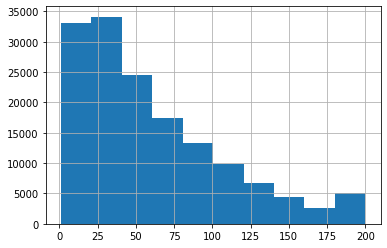

In [43]:
a.count_para.hist()

In [46]:
key_tb = a.copy()

In [47]:
key_tb.head()

,cik,fyear,count_para
0,20,1995,41
1,20,1996,31
2,20,1997,34
3,20,1998,49
4,20,1999,40


In [48]:
key_tb.tail()

,cik,fyear,count_para
151162,1688941,2016,126
151163,1689490,2016,55
151164,1690666,2016,109
151165,1691430,2016,46
151166,1695098,2016,27


- add fraud label

In [55]:
fraud_label = pd.read_excel('./fraud_label.xlsx')

In [56]:
fraud_label

,CONAME,CIK,YEARA
0,"21st Century Technologies, Inc.",1090870.0,2003.0
1,"3CI, Incorporated, now known as Cordero Indust...",718388.0,1984.0
2,"3CI, Incorporated, now known as Cordero Indust...",718388.0,1985.0
3,"3CI, Incorporated, now known as Cordero Indust...",718388.0,1986.0
4,"3Net Systems, Inc. now known as ALTERNATIVE TE...",885520.0,1991.0
...,...,...,...
2105,Zimmerman Sign Company,1027138.0,1999.0
2106,Zimmerman Sign Company,1027138.0,2000.0
2107,Zoltek,890923.0,2007.0
2108,"Zomax, Inc",1010788.0,2003.0


In [57]:
fraud_label.isnull().sum()

CONAME      0
CIK       345
YEARA       4
dtype: int64

In [58]:
fraud_label = fraud_label.dropna(subset=['CIK','YEARA'])

In [59]:
fraud_label.isnull().sum()

CONAME    0
CIK       0
YEARA     0
dtype: int64

In [60]:
fraud_label.CIK = fraud_label.CIK.astype(int)
fraud_label.YEARA = fraud_label.YEARA.astype(int)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [61]:
fraud_label['fraud'] = 1

<ipython-input-61-8b2893875419>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_label['fraud'] = 1


In [62]:
fraud_label.head()

,CONAME,CIK,YEARA,fraud
0,"21st Century Technologies, Inc.",1090870,2003,1
1,"3CI, Incorporated, now known as Cordero Indust...",718388,1984,1
2,"3CI, Incorporated, now known as Cordero Indust...",718388,1985,1
3,"3CI, Incorporated, now known as Cordero Indust...",718388,1986,1
4,"3Net Systems, Inc. now known as ALTERNATIVE TE...",885520,1991,1


In [67]:
print('total fraud: ', fraud_label.fraud.sum())
print('fraudulant comp: ', len(set(fraud_label.CIK)))

total fraud:  1765
fraudulant comp:  718


In [63]:
key_tb = key_tb.merge(fraud_label, left_on=['cik','fyear'], right_on=['CIK','YEARA'], how='left')

In [65]:
key_tb.head()

,cik,fyear,count_para,CONAME,CIK,YEARA,fraud
0,20,1995,41,NaN,NaN,NaN,NaN
1,20,1996,31,NaN,NaN,NaN,NaN
2,20,1997,34,NaN,NaN,NaN,NaN
3,20,1998,49,NaN,NaN,NaN,NaN
4,20,1999,40,NaN,NaN,NaN,NaN


In [68]:
key_tb.fraud.sum()

905.0

In [69]:
key_tb = key_tb.drop(['CONAME', 'CIK', 'YEARA'], axis=1)

In [71]:
key_tb.fraud = key_tb.fraud.fillna(0)

In [72]:
key_tb.head()

,cik,fyear,count_para,fraud
0,20,1995,41,0.0
1,20,1996,31,0.0
2,20,1997,34,0.0
3,20,1998,49,0.0
4,20,1999,40,0.0


In [76]:
key_tb.isnull().sum()

cik           0
fyear         0
count_para    0
fraud         0
dtype: int64

In [75]:
key_tb.shape

(151170, 4)

In [77]:
len(set(key_tb.cik))

20893

In [79]:
a = key_tb.groupby(['fyear']).agg(lambda x: x.eq(0).sum())
a = a.reset_index(drop=False)
a = a.rename(columns={'fraud':'non-fraud'})
a = a.drop(['cik','count_para'],axis=1)

In [80]:
b = key_tb.groupby(['fyear']).agg(lambda x: x.ne(0).sum())
b = b.reset_index(drop=False)
#b = b.rename(columns={'fraud':'non-fraud'})
b = b.drop(['cik','count_para'],axis=1)

In [83]:
c = pd.merge(a,b, on='fyear')

In [84]:
c

,fyear,non-fraud,fraud
0,1994,1793,6
1,1995,4040,17
2,1996,7922,34
3,1997,8311,54
4,1998,8216,57
5,1999,8696,79
6,2000,8744,91
7,2001,8266,92
8,2002,7649,81
9,2003,7298,76


 # create pos-neg pair

In [86]:
key_tb.head()

,cik,fyear,count_para,fraud
0,20,1995,41,0.0
1,20,1996,31,0.0
2,20,1997,34,0.0
3,20,1998,49,0.0
4,20,1999,40,0.0


In [92]:
key_tb.tail()

,cik,fyear,count_para,fraud
151165,1688941,2016,126,0.0
151166,1689490,2016,55,0.0
151167,1690666,2016,109,0.0
151168,1691430,2016,46,0.0
151169,1695098,2016,27,0.0


In [93]:
key_tb.iloc[0:1000,:]

cik           5981.0
fyear         1998.0
count_para      31.0
fraud            0.0
Name: 1000, dtype: float64

In [97]:
pos_neg_pair = pd.DataFrame()
for k, fr in key_tb.groupby('cik'):
    fr = fr.sort_values(['fyear'], ascending=True)
    fr['fyear_bf'] = fr.fyear.shift(1)
    pos_neg_pair = pd.concat([pos_neg_pair, fr])

In [96]:
pos_neg_pair

,cik,fyear,count_para,fraud,fyear_bf
0,20,1995,41,0.0,NaN
1,20,1996,31,0.0,1995.0
2,20,1997,34,0.0,1996.0
3,20,1998,49,0.0,1997.0
4,20,1999,40,0.0,1998.0
...,...,...,...,...,...
995,5910,2001,200,0.0,2000.0
996,5910,2002,200,0.0,2001.0
997,5981,1995,34,0.0,NaN
998,5981,1996,34,0.0,1995.0


In [98]:
pos_neg_pair.to_csv('./pos_neg_pair.csv',index=False)

In [100]:
pos_neg_pair.shape

(151170, 5)

In [99]:
pos_neg_pair.isnull().sum()

cik               0
fyear             0
count_para        0
fraud             0
fyear_bf      20893
dtype: int64

In [101]:
pos_neg_pair = pos_neg_pair.dropna()

In [102]:
pos_neg_pair.isnull().sum()

cik           0
fyear         0
count_para    0
fraud         0
fyear_bf      0
dtype: int64

In [103]:
pos_neg_pair.shape

(130277, 5)

In [108]:
a = pos_neg_pair.groupby(['fyear']).fraud.agg(lambda x: x.eq(0).sum())
a = a.reset_index(drop=False)
a = a.rename(columns={'fraud':'non-fraud'})
# a = a.drop(['cik','count_para'],axis=1)

In [109]:
a

,fyear,non-fraud
0,1995,1595
1,1996,3704
2,1997,7055
3,1998,7277
4,1999,7217
5,2000,7514
6,2001,7627
7,2002,7171
8,2003,6902
9,2004,6662


In [110]:
b = pos_neg_pair.groupby(['fyear']).fraud.agg(lambda x: x.ne(0).sum())
b = b.reset_index(drop=False)
#b = b.rename(columns={'fraud':'non-fraud'})
#b = b.drop(['cik','count_para'],axis=1)

In [111]:
b

,fyear,fraud
0,1995,8
1,1996,21
2,1997,49
3,1998,53
4,1999,70
5,2000,83
6,2001,89
7,2002,79
8,2003,75
9,2004,58


In [112]:
c = pd.merge(a,b, on='fyear')

In [113]:
c

,fyear,non-fraud,fraud
0,1995,1595,8
1,1996,3704,21
2,1997,7055,49
3,1998,7277,53
4,1999,7217,70
5,2000,7514,83
6,2001,7627,89
7,2002,7171,79
8,2003,6902,75
9,2004,6662,58
